<a href="https://colab.research.google.com/github/RafalDoroz/ai/blob/main/LIME_Image_Heatmap_Student_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📓 LIME na obrazach – interaktywny notebook

W tym notebooku możesz **wgrać dowolny obraz**, a model ResNet18 (wytrenowany na ImageNet) spróbuje go sklasyfikować.

Dzięki **LIME** zobaczysz, które części obrazu były **najważniejsze dla modelu** przy podejmowaniu decyzji.

## 1️⃣ Instalacja bibliotek

In [1]:
!pip install lime torch torchvision pillow matplotlib scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha2

## 2️⃣ Import wymaganych bibliotek

In [2]:
import numpy as np
import torch
from torchvision import models, transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

## 3️⃣ Wczytanie modelu ResNet18

In [3]:
# Ładujemy wstępnie wytrenowany model ResNet18
model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4️⃣ Funkcje pomocnicze (transformacje i predykcja)

In [4]:
# Transformacja obrazu do formatu wymaganego przez ResNet18
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Funkcja predykcji dla LIME
def predict(images):
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0)
    with torch.no_grad():
        preds = model(batch)
        probs = torch.nn.functional.softmax(preds, dim=1)
    return probs.numpy()

## 5️⃣ Wgraj swój obraz

Saving dog.jpg to dog.jpg


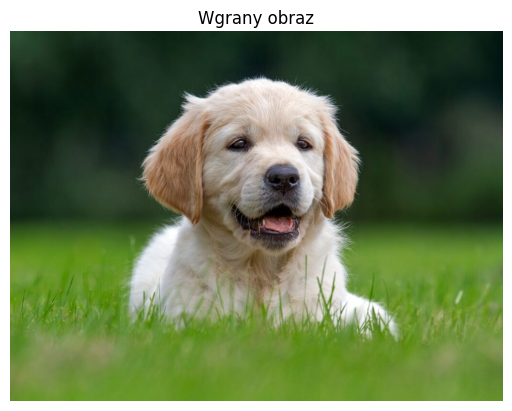

In [5]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Wyświetlamy wgrany obraz
img = Image.open(image_path)
plt.imshow(img)
plt.title("Wgrany obraz")
plt.axis("off")
plt.show()

## 6️⃣ Wyjaśnienie predykcji przy pomocy LIME

In [6]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    np.array(img),
    predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 7️⃣ Heatmapa LIME – które obszary były najważniejsze?

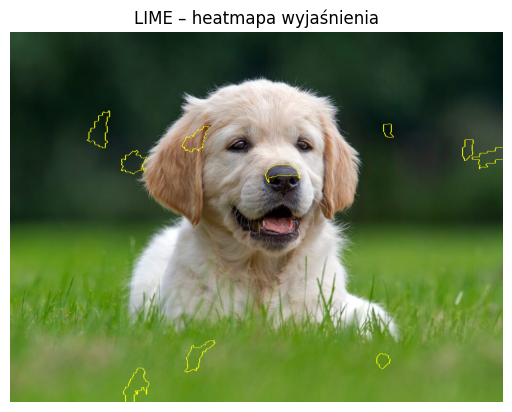

In [7]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME – heatmapa wyjaśnienia")
plt.axis("off")
plt.show()